# Assignment 03

<font color='red'>Running all cells in this notebook might take 2-3 minutes!</font>

In [1]:
%matplotlib inline

In [2]:
from Data import Data
from NBC import Model, average_accuracy
from Vocabulary import Vocabulary
import pandas as pd
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Reading the vocabulary file included with the data folder.
<br>
See [Vocabulary.py](Vocabulary.py)

In [3]:
vocab = Vocabulary(r'aclImdb\\imdb.vocab')

In [4]:
print(f'Stopwords: {vocab.stopwords}')

Stopwords: {'further', 'while', 'above', 'itself', 'before', 'has', 'them', 'yourself', 'your', "aren't", 'other', 'with', 'down', "couldn't", 'if', 'hasn', 're', 'any', 'its', 'ma', 'd', 'had', 'who', 'out', 'weren', 'the', 'doing', "mustn't", "wasn't", 'wasn', 'be', 'such', 's', 'haven', 'couldn', 'ourselves', 'y', "shouldn't", 'in', "haven't", 'for', 'only', "should've", "needn't", 'into', 'shouldn', "she's", "won't", 'wouldn', 'doesn', 'than', 'me', 'shan', 'again', 'mustn', 'will', 'needn', 'at', 'between', "hasn't", "don't", 'a', 'yours', 'both', 'myself', 'but', 'under', 'when', 'they', 'just', 'themselves', 'each', 'why', 'am', 'on', "you'd", 'does', 'she', 'as', 'nor', "you've", "shan't", 'against', 'no', "weren't", 'their', 'then', 'herself', 'my', 'm', 'can', 'this', "it's", 'been', 'it', 'once', "mightn't", 'or', 'don', 'do', "doesn't", 'an', 'not', 'our', 'being', 'won', 't', 'about', 'how', 'mightn', 'more', "wouldn't", 'because', 'hers', 'whom', 'him', 'were', 'through',

Reading the [train](aclImdb/train/labeledBow.feat) reviews file using 5 fold cross-validation.

See [Data.py](Data.py) and [Reviews.py](Reviews.py)

In [5]:
k = 5
data_sets = list(Data.read_train('aclImdb', k))

Creating NBC models for each of the data set that was produced by 5 fold cross-validation.
<br>
See [NBC.py](NBC.py)

In [6]:
models = [Model(x.train, vocab) for x in data_sets]
print(f'{len(models)} NBC models created from the data sets')

5 NBC models created from the data sets


In [7]:
reviews = data_sets[0].all_train
index_the = vocab.get_index('the')

Calculating $P[“the”]$ = num of documents containing ‘the’ / num of all documents

In [8]:
print(f'P["the"] = {reviews.count(index_the) / len(reviews.all)}')

P["the"] = 0.99168


Calculating $P[“the” | Positive]$ = # of positive documents containing “the” / num of all positive review documents

In [9]:
print(f'P["the" | Positive] = {reviews.count_positive(index_the) / len(reviews.positive)}')
print(f'P["the" | Negative] = {reviews.count_negative(index_the) / len(reviews.positive)}')

P["the" | Positive] = 0.99048
P["the" | Negative] = 0.99288


Calculating the average accuracy of these models without any smoothing and ignoring stop words only.
<br>
`average_accuracy()` is defined in [NBC.py](NBC.py)

In [10]:
dev_data = [x.dev for x in data_sets]
accuracy = average_accuracy(models, dev_data, smoothen=0, min_occurrence=0)
print(f'Average accuracy = {accuracy:.4%}')

Average accuracy = 74.8000%


Calculating the average accuracy using smoothing hyperparameters in the range $[0, 1]$ with step size $0.1$

In [11]:
h_params = {}
for i in (x * 0.1 for x in range(0, 11)):
    h_params[i] = average_accuracy(models, dev_data, smoothen=i, min_occurrence=0)
smoothing_accuracies = pd.DataFrame.from_dict(h_params, orient='index', columns=['Accuracy'])

In [12]:
smoothing_accuracies

Accuracy
0.0   0.74800
0.1   0.85288
0.2   0.85560
0.3   0.85616
0.4   0.85696
0.5   0.85784
0.6   0.85808
0.7   0.85796
0.8   0.85776
0.9   0.85784
1.0   0.85784

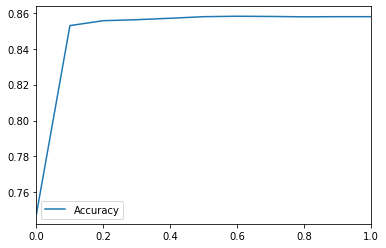

In [13]:
smoothing_accuracies.plot()

It's worth noting that increase the smoothing parameter from `0` even in the slightest increases accuracy considerably.
<br>
This is because a lot of the words were forcing the probability calculation to be `0`
<br>
rendering any other words in the same review useless.

The second hyperparameter to optimize is `min_occurrence`.
<br>
`min_occurence` specifes the percentage of total reviews that a word must occur in for it to be considered.
<br>
`min_occurence=0.00025` implies that a word must occur in atleast $0.025\%$ of the reviews i.e. $5/20000$

In [14]:
h_params = {}
for i in (x * 0.00025 for x in range(0, 11)):
    h_params[i] = average_accuracy(models, dev_data, smoothen=0, min_occurrence=i)
min_occurrence_accuracies = pd.DataFrame.from_dict(h_params, orient='index', columns=['Accuracy'])

In [15]:
min_occurrence_accuracies

Accuracy
0.00000   0.74800
0.00025   0.83232
0.00050   0.85056
0.00075   0.85140
0.00100   0.85208
0.00125   0.85224
0.00150   0.85220
0.00175   0.85208
0.00200   0.85180
0.00225   0.85048
0.00250   0.85016

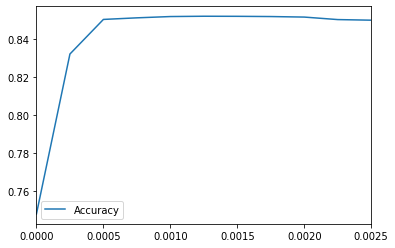

In [16]:
min_occurrence_accuracies.plot()

The accuracy improves significantly if we ignore words that occur rarely, 
<br>
specially those that occur $0$ times in either `Positive` or `Negative` class.
<br>
The above plot is for varying values of `min_occurence` on x-axis with `smoothen=0`.

Redrawing the same plot with `smoothen=1`.

In [17]:
h_params = {}
for i in (x * 0.00025 for x in range(0, 11)):
    h_params[i] = average_accuracy(models, dev_data, smoothen=1, min_occurrence=i)
min_occurrence_accuracies = pd.DataFrame.from_dict(h_params, orient='index', columns=['Accuracy'])
min_occurrence_accuracies.plot()

The accuracy is now decereasing but the change in accuracy is rather small in comparison to before.
<br>
Simply maximizing both the hyperparameters does not yield better results.
<br>
The ideal model is a balance between the 2 hyperparameters which is rather expensive to compute in this example.

For the final accuracy calculation, `smoothen=1` and `min_occurrence=0.00025` is used.
<br>
[train](aclImdb/train/labeledBow.feat) and [test](aclImdb/test/labeledBow.feat) reviews are combined and used in 5 fold cross-validation for the final models.

In [18]:
data_sets = list(Data.read_all('aclImdb', k))

In [19]:
models = [Model(x.train, vocab) for x in data_sets]

In [20]:
test_data = [x.test for x in data_sets]
accuracy = average_accuracy(models, test_data, smoothen=1, min_occurrence=0.00025)
print(f'Average accuracy = {accuracy:.4%}')

Average accuracy = 85.7600%


In [21]:
pos_words, neg_words = models[0].top_words(top_count=10, min_occurrence=0)
print(f'Top 10 positive predicting words:\n{pos_words}')
print()
print(f'Top 10 negative predicting words:\n{neg_words}')

Top 10 positive predicting words:
['gundam', 'gunga', 'kells', 'harilal', 'panahi', 'khouri', 'sullavan', 'hilliard', 'jaffar', 'offside']

Top 10 negative predicting words:
['tashan', 'hobgoblins', 'kareena', 'kornbluth', 'sarne', 'gram', 'lommel', 'delia', 'saif', 'darkman']


The top words seem like typos or otherwise meaningless because 
<br>
these words occured just once in their prediction class and never occured again.

In [22]:
pos_words, neg_words = models[0].top_words(top_count=10, min_occurrence=0.01)
print(f'Top 10 positive predicting words:\n{pos_words}')
print()
print(f'Top 10 negative predicting words:\n{neg_words}')

Top 10 positive predicting words:
['wonderfully', 'superb', 'beautifully', 'touching', 'outstanding', 'gem', 'magnificent', 'friendship', 'remarkable', 'excellent']

Top 10 negative predicting words:
['waste', 'redeeming', 'laughable', 'worst', 'poorly', 'awful', 'pointless', 'lame', 'sucks', 'pathetic']


The top words now seem meaningful after filtering out words that occur too rarely (in less than $1\%$ of the reviews).